In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit as scipy_curve_fit
from scipy.stats import laplace
import time

from emely import curve_fit as emely_curve_fit

In [2]:
# define plot style
violet = "#785ef0"
blue = "#648fff"
yellow = "#ffb000"
orange = "#fe6100"
red = "#dc267f"
black = "000000"
gray = "cccccc"
white = "ffffff"

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.dpi"] = 300

### Overview

This notebook performs tests to validate the parameter estimates and covariance matrices obtained when fitting a Gaussian model with **Laplace noise**. 

The estimated parameters and covariances from the MLE implementation are compared against:

- The parameter estimates and covariances from scipy.optimize.curve_fit.
- The empirical covariance matrices obtained by repeatedly fitting noisy datasets generated from the same Gaussian model.

### Model and noise

We estimate the parameters $\theta = (a, \mu, \sigma)$ of a normalized Gaussian function:

$
f(x, \theta) = \frac{a}{\sqrt{2\pi\,\sigma^2}} \, e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$,

from noisy measurements

$
y(x) = f(x, \theta) + \varepsilon
$,

where the noise term $ \varepsilon $ follows **Laplace statistics**. 

### Physical Context

This setup reflects a intensity measurement where the amplitude $a$ is given by the incident power $P$

$
a = P
$.

In [3]:
# define the model to fit
def gaussian(x, a, mu, sigma):
    return a / np.sqrt(2 * np.pi * sigma**2) * np.exp(-((x - mu) ** 2) / (2 * sigma**2))

In [4]:
# define estimators
estimators = {
    "Least-Squares": lambda f,
    xdata,
    ydata,
    p0,
    bounds,
    sigma,
    absolute_sigma: scipy_curve_fit(
        f,
        xdata,
        ydata,
        p0=p0,
        bounds=bounds,
        sigma=sigma,
        absolute_sigma=absolute_sigma,
    ),
    "Gaussian-MLE": lambda f,
    xdata,
    ydata,
    p0,
    bounds,
    sigma,
    absolute_sigma: emely_curve_fit(
        f,
        xdata,
        ydata,
        p0=p0,
        bounds=bounds,
        sigma=sigma,
        absolute_sigma=absolute_sigma,
        noise="gaussian",
    ),
    "Laplace-MLE": lambda f,
    xdata,
    ydata,
    p0,
    bounds,
    sigma,
    absolute_sigma: emely_curve_fit(
        f,
        xdata,
        ydata,
        p0=p0,
        bounds=bounds,
        sigma=sigma,
        absolute_sigma=absolute_sigma,
        noise="laplace",
    ),
}

In [5]:
# define model parameters
dx = 10e-9  # (m)
mu = 0  # (m)
sigma = 300e-9  # (m)
P = 5e-3  # (W)
p = (P, mu, sigma)

# define model variables
x_rng = (-3 * sigma, 3 * sigma)
n_x = round((x_rng[1] - x_rng[0]) / dx) + 1
x = x_rng[0] + dx * np.arange(n_x)

# set the random seed
np.random.seed(0)

In [6]:
# create N measurements
f_x = gaussian(x, *p)
N = 1_000

# define the noise parameters
sigma_noise = 3e3  # (W/m)

# parameter estimates
p_opt = {name: np.zeros((N, len(p))) for name in estimators}
p_cov = {name: np.zeros((N, len(p), len(p))) for name in estimators}

# track run times
run_times = {name: np.zeros(N) for name in estimators}

y_x = np.zeros((N, n_x))
for ii in range(N):
    # add noise to measurement
    y_x[ii, :] = f_x + laplace.rvs(scale=sigma_noise / np.sqrt(2), size=n_x)

    # define initial guesses
    P_0 = np.sum(y_x[ii, :] * dx)
    a_0 = P_0
    mu_0 = np.sum(x * y_x[ii, :] * dx) / P_0  # (m)
    var_0 = np.sum((x - mu_0) ** 2 * y_x[ii, :] * dx) / P_0  # (m^2)
    sigma_0 = np.sqrt(var_0) if var_0 > 0 else 1e-10  # (m)
    p_0 = (a_0, mu_0, sigma_0)

    # define bounds
    bounds = (
        [1e-18, -np.inf, 1e-18],
        [np.inf, np.inf, np.inf],
    )

    for name in estimators:
        try:
            t_1 = time.perf_counter()

            p_opt[name][ii, :], p_cov[name][ii, :, :] = estimators[name](
                gaussian,
                x,
                y_x[ii, :],
                p0=p_0,
                bounds=bounds,
                sigma=sigma_noise,
                absolute_sigma=True,
            )

            t_2 = time.perf_counter()
            run_times[name][ii] = t_2 - t_1
        except RuntimeError:
            p_opt[name][ii, :] = np.nan * np.ones(len(p))
            p_cov[name][ii, :, :] = np.nan * np.ones((len(p), len(p)))

            run_times[name][ii] = np.nan

In [7]:
# print run time statistics
for name in estimators:
    print(
        f"{name}: {1e3 * np.nanmean(run_times[name]):.2f} +/- {1e3 * np.nanstd(run_times[name]):.2f} ms"
    )

Least-Squares: 3.67 +/- 2.83 ms
Gaussian-MLE: 13.60 +/- 8.02 ms
Laplace-MLE: 25.20 +/- 14.26 ms


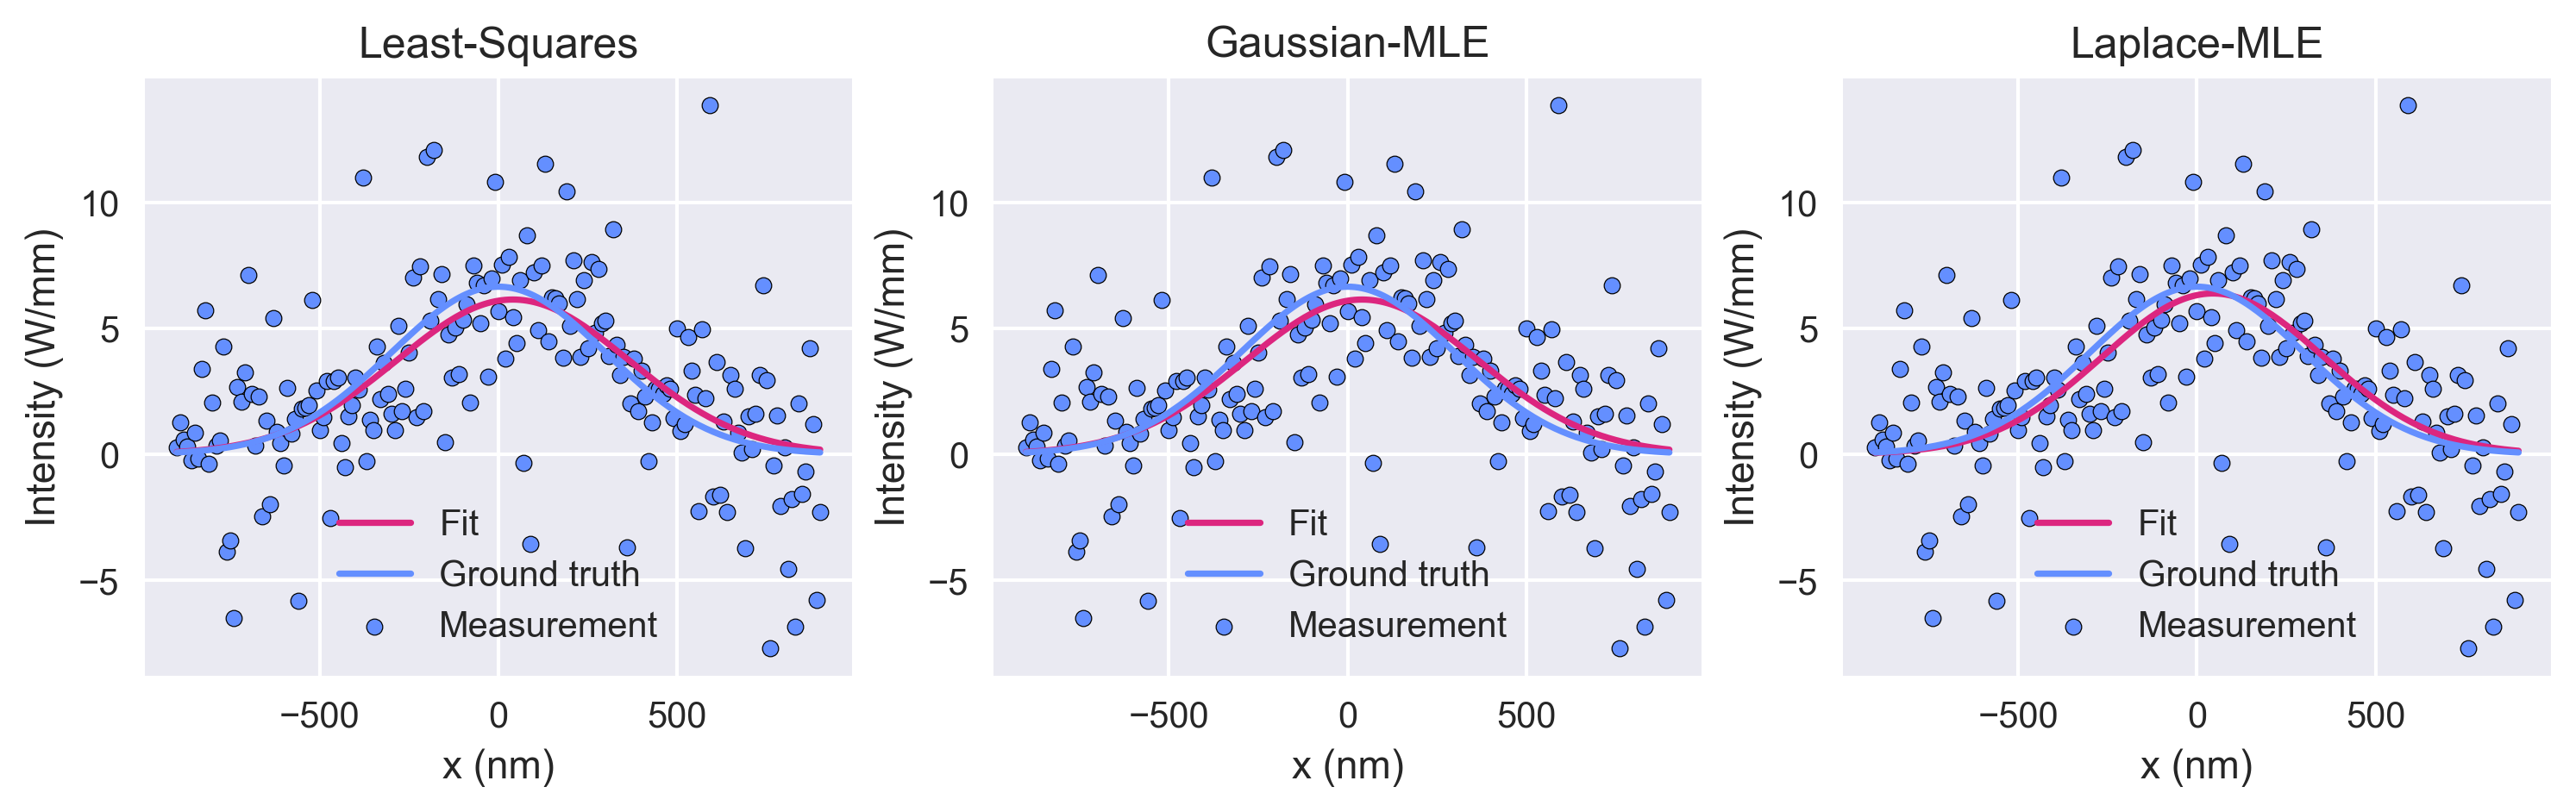

In [8]:
# show exemplary data and fit
fig, axs = plt.subplots(1, len(estimators), figsize=(4 * len(estimators), 3))

index = 0
for ii, name in enumerate(estimators):
    axs[ii].plot(
        1e9 * x, 1e-3 * gaussian(x, *p_opt[name][index, :]), color=red, label="Fit"
    )
    axs[ii].plot(1e9 * x, 1e-3 * gaussian(x, *p), color=blue, label="Ground truth")
    axs[ii].scatter(
        1e9 * x,
        1e-3 * y_x[index, :],
        s=20,
        edgecolor=black,
        facecolor=blue,
        label="Measurement",
    )
    axs[ii].legend()
    axs[ii].set_title(name)

    axs[ii].set_xlabel("x (nm)")
    axs[ii].set_ylabel("Intensity (W/mm)")


In [9]:
# parameter settings
colors = [red, yellow, blue]
parameter_names = ["Amplitude", "Center", "Width"]
parameter_units = ["(W/mm)", "(nm)", "(nm)"]
parameter_scaling = [1e3, 1e9, 1e9, 1e9]

# parameter estimates
parameter_estimates = {
    parameter_name: pd.DataFrame({}, columns=estimators.keys())
    for parameter_name in parameter_names
}
for ii, parameter_name in enumerate(parameter_names):
    for estimator_name in estimators:
        parameter_estimates[parameter_name][estimator_name] = p_opt[estimator_name][
            :, ii
        ]

# empirical and estimated standard deviations
p_emp_std = {}
p_est_std = {}
for ii, parameter_name in enumerate(parameter_names):
    p_emp_std[parameter_name] = {}
    p_est_std[parameter_name] = {}
    for estimator_name in estimators:
        p_emp_std[parameter_name][estimator_name] = np.sqrt(
            np.nanvar(p_opt[estimator_name][:, ii], axis=0)
        )
        p_est_std[parameter_name][estimator_name] = np.sqrt(
            np.nanmean(p_cov[estimator_name][:, ii, ii], axis=0)
        )

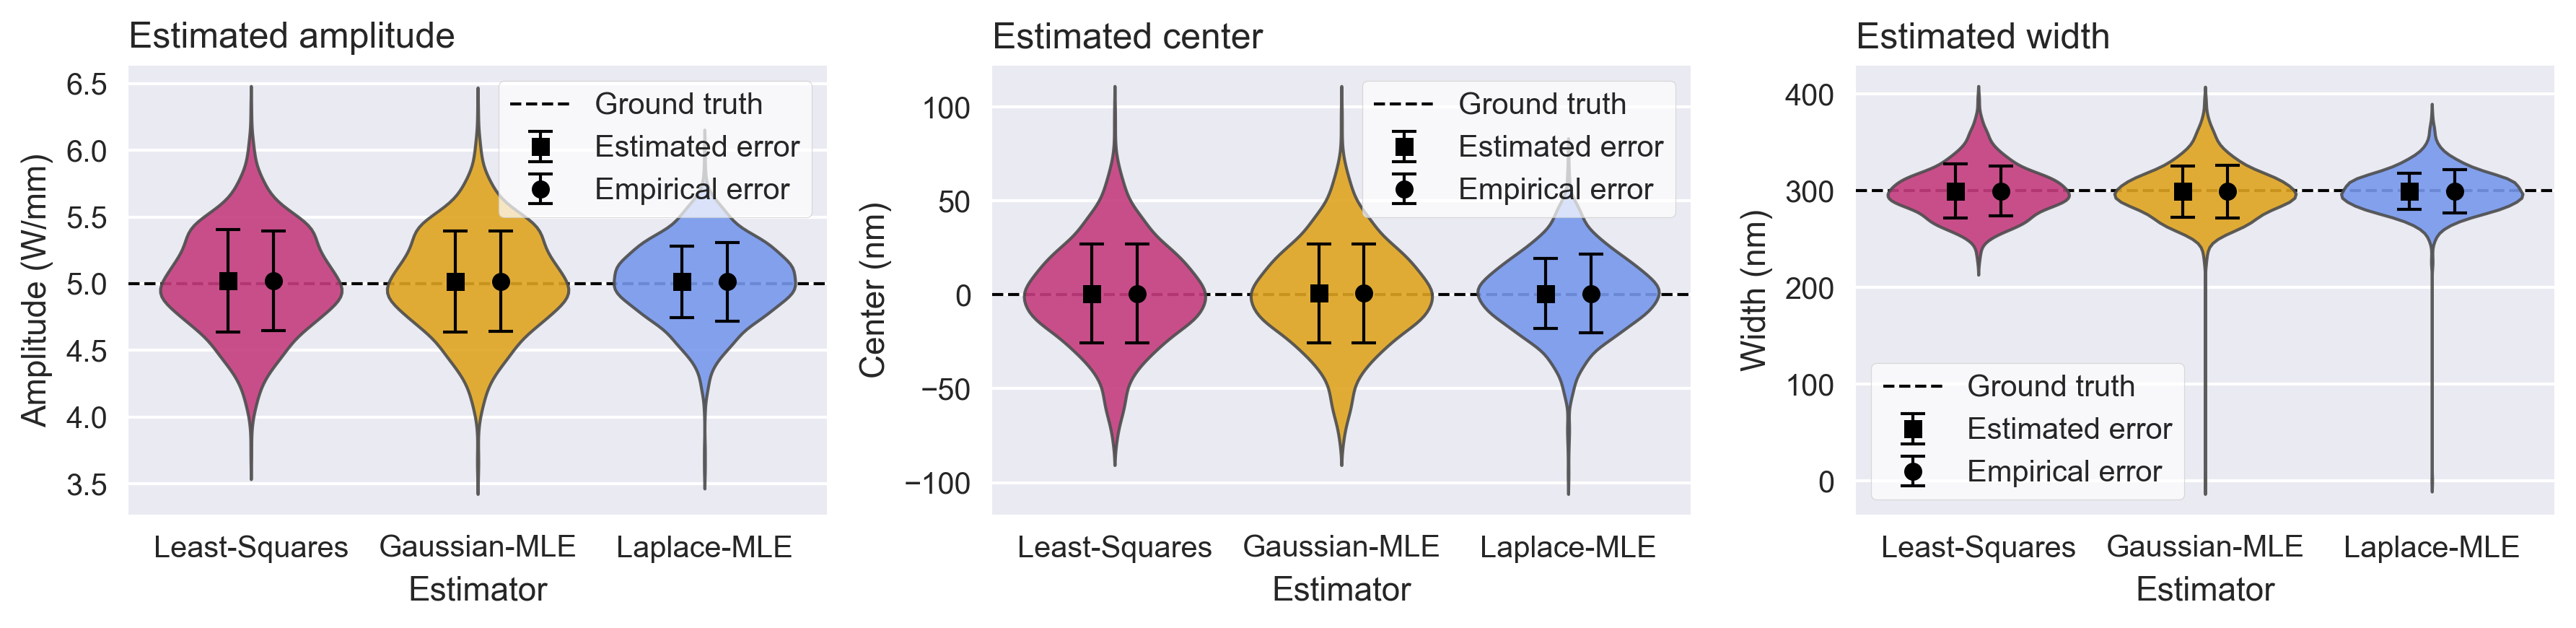

In [10]:
fig, axs = plt.subplots(1, len(p), figsize=(4 * len(p), 3))

for ii in range(len(p)):
    sns.violinplot(
        parameter_scaling[ii] * parameter_estimates[parameter_names[ii]],
        inner=None,
        palette=colors,
        linewidth=1,
        alpha=0.9,
        ax=axs[ii],
        zorder=10,
    )

    offset = 0.1
    location = np.arange(len(estimators))
    y = [
        parameter_scaling[ii]
        * parameter_estimates[parameter_names[ii]][estimator_name].mean()
        for estimator_name in estimators
    ]

    # estimated standard deviation
    yerr = [
        parameter_scaling[ii] * p_est_std[parameter_names[ii]][estimator_name]
        for estimator_name in estimators
    ]
    axs[ii].errorbar(
        location - offset,
        y,
        yerr=yerr,
        color=black,
        linewidth=1,
        fmt="s",
        markersize=6,
        capthick=1,
        capsize=4,
        label="Estimated error",
        zorder=15,
    )

    # empirical standard deviation
    yerr = [
        parameter_scaling[ii] * p_emp_std[parameter_names[ii]][estimator_name]
        for estimator_name in estimators
    ]
    axs[ii].errorbar(
        location + offset,
        y,
        yerr=yerr,
        color=black,
        linewidth=1,
        fmt="o",
        markersize=6,
        capthick=1,
        capsize=4,
        label="Empirical error",
        zorder=15,
    )

    # ground truth
    axs[ii].axhline(
        parameter_scaling[ii] * p[ii],
        color=black,
        linestyle="--",
        linewidth=1,
        label="Ground truth",
        zorder=5,
    )

    axs[ii].set_title("Estimated " + parameter_names[ii].lower(), loc="left")
    axs[ii].set_xlabel("Estimator")
    axs[ii].set_ylabel(parameter_names[ii] + " " + parameter_units[ii])
    legend = axs[ii].legend(frameon=True, framealpha=0.7)
    legend.get_frame().set_facecolor("white")
    legend.set_zorder(20)

fig.tight_layout()